//Copyright (c) Microsoft Corporation. All rights reserved. 
//Licensed under the MIT License.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import keras 
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist,cifar10
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from scipy import stats
import tensorflow as tf
import warnings
import PrivacyGAN as pg 
from keras.models import load_model
from datetime import datetime


warnings.filterwarnings("ignore")
K.set_image_dim_ordering('th')

### Load dataset 

In [2]:
# Load MNIST data and concatenate the train+test set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_test = (X_test.astype(np.float32) - 127.5)/127.5
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_all = np.concatenate((X_train,X_test))


#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print('training set size:',X.shape)
print('test set size:',X_comp.shape)

training set size: (7000, 784)
test set size: (63000, 784)


### Test Simple GAN 

In [3]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 500, batchSize = 256)

Epochs: 500
Batch size: 256
Batches per epoch: 27.34375
epoch = 1/500, d_loss=0.535, g_loss=0.754                                                                                                                    
epoch = 2/500, d_loss=0.584, g_loss=0.782                                                                                                                    
epoch = 3/500, d_loss=0.540, g_loss=0.890                                                                                                                    
epoch = 4/500, d_loss=0.464, g_loss=0.992                                                                                                                    
epoch = 5/500, d_loss=0.450, g_loss=1.115                                                                                                                    
epoch = 6/500, d_loss=0.486, g_loss=1.175                                                                                                                 

In [4]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.5381428571428571


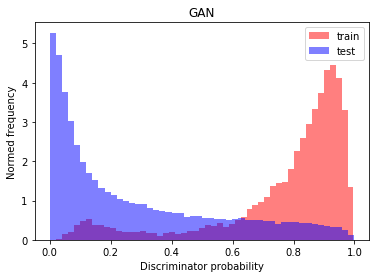

In [5]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

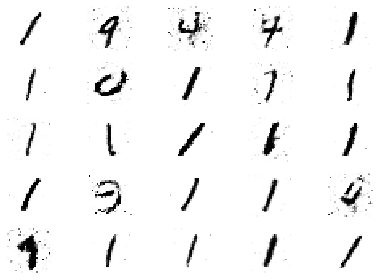

In [6]:
#Generate fake images
pg.DisplayImages(generator, figSize=(5,5), NoImages = 25)

### Test privGAN

In [ ]:
### Test privGAN (with n_reps = 2)
K.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generators = [pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              pg.MNIST_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
                  ,pg.MNIST_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = pg.MNIST_DiscriminatorPrivate(OutSize = 2, 
                                      optim = Adam(lr=0.0002, beta_1=0.5))

(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 500, 
                                                                           disc_epochs=50,
                                                                           batchSize=256,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio = 1.0)

Train on 7000 samples, validate on 7000 samples
Epoch 1/50
7000/7000 [==============================] - 1s 95us/step - loss: 0.7639 - val_loss: 0.6869
Epoch 2/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6974 - val_loss: 0.6839
Epoch 3/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6910 - val_loss: 0.7293
Epoch 4/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6905 - val_loss: 0.6744
Epoch 5/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6814 - val_loss: 0.6713
Epoch 6/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6831 - val_loss: 0.6679
Epoch 7/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6754 - val_loss: 0.6781
Epoch 8/50
7000/7000 [==============================] - 0s 16us/step - loss: 0.6680 - val_loss: 0.6730
Epoch 9/50
7000/7000 [==============================] - 0s 17us/step - loss: 0.6659 - val_loss: 0.6821
Epoch 10/50
7000/7000 [==

In [8]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.2102857142857143
White-box attack accuracy (mean): 0.16557142857142856


(0.2102857142857143, 0.16557142857142856)

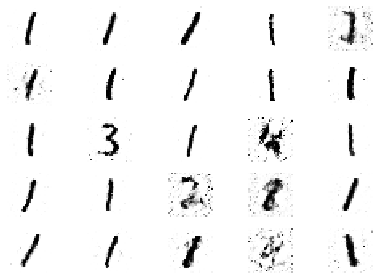

In [18]:
#Generate fake images
pg.DisplayImages(generators[1], figSize=(5,5), NoImages = 25)

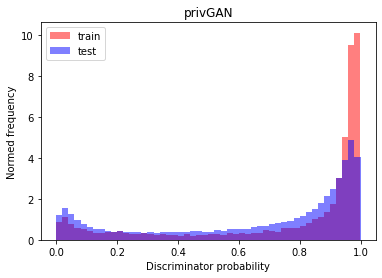

In [19]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', normed = 1, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', normed = 1, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN')
plt.legend()